**Model Skeleton**

Click [here](https://docs.google.com/document/d/15i4WKK-kaqgAb90PQ_iMbMJgdA57clu9iYEen_DVmyc/edit?usp=sharing) for a detailed description of the purpose of every code chunk

**Make sure to run this script on Google Colab to ensure compatability with Drive mounting**

**0) Import Dependencies and Mount Drive**

In [3]:
# ─── Standard Library ───────────────────────────────────────────────────────
import os
import re
import glob
import time
import struct
import random
import shutil
from datetime import datetime
from collections import Counter, OrderedDict
from concurrent.futures import ThreadPoolExecutor, as_completed
from pathlib import Path

# ─── Data Handling ──────────────────────────────────────────────────────────
import numpy as np
import pandas as pd

# ─── Visualization ──────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns

# ─── Machine Learning & PyTorch ─────────────────────────────────────────────
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.nn.functional import softmax
from torch.utils.data import Dataset, DataLoader, Sampler, random_split
import torch.backends.cudnn as cudnn
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# ─── Computer Vision ────────────────────────────────────────────────────────
from torchvision import datasets, transforms, models
from torchvision.transforms.functional import pad
from torchvision.utils import save_image
from PIL import Image, UnidentifiedImageError
import cv2
from skimage import io, color
import timm  # For accessing pretrained models beyond torchvision

# ─── Metrics & Evaluation ───────────────────────────────────────────────────
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)

# ─── Progress Monitoring ────────────────────────────────────────────────────
from tqdm.auto import tqdm

# ─── Reproducibility ────────────────────────────────────────────────────────
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [4]:
# Connect to Google Drive - remember to make a shortcut of the "Patches" folder to "My Drive"
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


**1. Configuration**

*Contains everything we can change about the model besides the model itself. The only other part of the code you should need to modify is in the section "Define Your Model and Train"*

- Paths to our data (**update these paths with the paths from your own drive**)
    - drive_image_folder (this is the drive folder with all images)
    - label_csv (this is the path with true labels "case_grade_match.csv")
    - meta_csv_full_scan (this is the path where the metadata is saved)

- Data to train on (**update these params with the cases you want to train on**)
    - train_cases
    - test_cases
    - validation_cases

- Filtering Parameters (**update these params with the stains and sizes you want to train on**)
    - target_stain
    - min_image_size
    - max_image_size
- Hyperparameters
    - lr (learning rate)
    - num_epochs (number of epochs)
    - batch_size

- Other Parameters
    - force_rebuild_metadata_full
        - This will rebuild the metadata each time
        - **Only set to false if you have not changed any other parameters** (meaning that your filtering params and data to train on have not changed)

    - Device
        - Controls what hardware (GPU vs. CPU etc) we use (defualt GPU)
    - num_workers
        - Param for the data loader. If num_workers > 0, we load + preprocess data in parallel with model training.
        - currently not in use bc data loading is fast




In [5]:
import os
from google.colab import drive
import shutil

# 1. Mount Google Drive (skip remount warning)
drive.mount('/content/drive')

# 2. Paths
zip_path = '/content/drive/MyDrive/STAT_390/Patches_Apr27.zip'
extract_dir = '/content/Patches_Apr27'

# 3. Remove any previous partial extraction
if os.path.exists(extract_dir):
    print("🗑️ Removing old extract folder...")
    shutil.rmtree(extract_dir)

# 4. Re-unzip using shell unzip (handles large files better)
print("📦 Re-unzipping ZIP to /content...")
!unzip -q -o "$zip_path" -d "/content"
print("✅ Unzipping complete.")

# 5. Count image files
image_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'}
image_files = []
for root, _, files in os.walk(extract_dir):
    for f in files:
        if os.path.splitext(f)[1].lower() in image_exts:
            image_files.append(os.path.join(root, f))

print(f"📸 Total image files after fresh unzip: {len(image_files)}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📦 Re-unzipping ZIP to /content...
✅ Unzipping complete.
📸 Total image files after fresh unzip: 73301


In [6]:
# ─── 1) CONFIG (Updated for Full Scan) ──────────────────────────────────
CONFIG = {
    'local_image_folder': extract_dir,  # read directly
    'label_csv': "/content/drive/MyDrive/STAT_390/case_grade_match.csv",
    'meta_csv_full_scan': "/content/drive/MyDrive/STAT_390/metadata_full_scan.csv",  # Distinct name for full metadata
    'batch_size': 16, # Example batch size
    'num_workers': 4, # Number of workers for metadata scanning and DataLoader
    'lr': 1e-4, # Example learning rate
    'num_epochs': 15, # Example epochs
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'), # Example device
    'resize_max': 512, # Example resize size for transforms (used in filtering/bucketing)
    'train_cases': [2,4,22,24,26,28,30,34,36,53,79,82,86,96,1,5,9,12,17,18,32,40,42,44,48,49,51,54,55,58,66,67,68,69,70,72,80,87,88,91,92,95,99,100,104,59,16],
    'test_cases': [23,27,45,46,78,85,14,15,19,38,50,65,83,84,97], #[34,1,99,62,89,2,12],
    'validation_cases':[21,25,43,56,93,94,3,7,11,47,57,64,73,75,98], #[12,90,21,3,85,25,98],
    'force_rebuild_metadata_full': True, # DO NOT change to False (unless you have not made any adjustments to cases, stain, or image size restrictions)
    'min_image_size': 50, # Used for filtering AFTER full scan
    'max_image_size': 100000, # Used for filtering AFTER full scan
    # --- Keep stains as a list for filtering later ---
    'target_stain': 'h&e' # Specify which stain to train/evaluate on for this run
}
# Combine all cases from train/val/test for the initial full metadata scan
all_cases_for_scan = set(CONFIG['train_cases'] + CONFIG['test_cases'] + CONFIG['validation_cases'])
print(f"Cases included in initial full metadata scan: {len(all_cases_for_scan)}")
print(f"Target stain for this run: {CONFIG['target_stain']}")

Cases included in initial full metadata scan: 77
Target stain for this run: h&e


**2) Build Metadata**

Uses 3 code chunks

1) Helper functions: help optimize build_metadata function

2) Build metadata function: creates metadata

3) Calling build metadata

In [7]:
# ─── 1) HELPERS ──────────────────────────────────────────────────────────────
# Regex for filenames like "case_001_match_…png" or "case_12_unmatched_…png"
case_pat = re.compile(r'case_0*(\d+)_(?:match|unmatched)_', re.IGNORECASE)

def fast_scan(root, max_retries=3, backoff=1.5):
    """
    Efficiently and safely scans a directory tree for .png files.
    Automatically retries failed directory reads (useful for Google Drive in Colab).

    Args:
        root (str): Root directory to scan.
        max_retries (int): Max retries per failed directory.
        backoff (float): Base multiplier for exponential delay between retries.
    """
    def scan_dir(path, retries=0):
        try:
            for entry in os.scandir(path):
                if entry.is_file() and entry.name.lower().endswith('.png'):
                    yield entry.path
                elif entry.is_dir():
                    yield from scan_dir(entry.path)
        except OSError as e:
            if retries < max_retries:
                wait = backoff ** retries
                print(f"⚠️  I/O error on {path} (attempt {retries+1}/{max_retries}). Retrying in {wait:.1f}s...")
                time.sleep(wait)
                yield from scan_dir(path, retries + 1)
            else:
                print(f"❌ Skipping {path} after {max_retries} failed attempts.")

    return scan_dir(root)

In [8]:
# ─── 2) OPTIMIZED METADATA BUILDER ───────────────────────────────────────────
def build_metadata(image_folder, all_cases, meta_csv, stain,
                   force_rebuild=False, min_width=0, max_width=float('inf'),
                   num_workers=4):
    """
    Builds or loads a filtered metadata DataFrame:
      - only cases in `all_cases`
      - only files whose paths contain `stain`
      - only images with width/height in (min_width,max_width) or unknown dims (-1)
    """
    # Try loading existing CSV
    if os.path.exists(meta_csv) and not force_rebuild:
        try:
            df = pd.read_csv(meta_csv)
            required = {'path','case_number','stain','width','height'}
            if required.issubset(df.columns):
                # apply filters
                df = df[df.case_number.isin(all_cases)]
                df = df[((df.width  > min_width) & (df.width  < max_width)) | (df.width  == -1)]
                df = df[df.stain.str.lower() == stain.lower()]
                print(f"Loaded & filtered {len(df)} rows from {meta_csv}")
                return df
        except Exception:
            print(f"❗ Corrupt or missing `{meta_csv}`; rebuilding…")

    # Full rescan
    print(f"🔍 Scanning {image_folder} for stain='{stain}'…")
    files = list(fast_scan(image_folder))
    if not files:
        print(f"⚠️  No PNG files found in {image_folder}")
        return pd.DataFrame(columns=['path','case_number','stain','width','height'])

    def proc(p):
        m = case_pat.search(os.path.basename(p))
        if not m:
            return None
        cid = int(m.group(1))
        # case filter
        if cid not in all_cases:
            return None
        # stain filter
        if stain.lower() not in p.lower():
            return None
        # fast-header read
        w, h = -1, -1
        try:
            with open(p,'rb') as f:
                hdr = f.read(24)
            if hdr.startswith(b'\x89PNG\r\n\x1a\n') and hdr[12:16] == b'IHDR':
                w = struct.unpack('>I',hdr[16:20])[0]
                h = struct.unpack('>I',hdr[20:24])[0]
            else:
                with Image.open(p) as img:
                    w, h = img.size
        except Exception:
            pass
        # size filter
        if w != -1 and not (min_width < w < max_width):
            return None
        return {
            'path': p,
            'case_number': cid,
            'stain': stain.lower(),
            'width': w,
            'height': h
        }

    with ThreadPoolExecutor(max_workers=num_workers) as exe:
        rows = list(tqdm(exe.map(proc, files), total=len(files)))
    df = pd.DataFrame([r for r in rows if r])
    if df.empty:
        print(f"⚠️  No metadata built for stain='{stain}'")
        return df

    df.to_csv(meta_csv, index=False)
    print(f"✅ Built & saved {len(df)} rows to {meta_csv}")
    return df

In [9]:
# create metadata
full_meta_df = build_metadata(
    image_folder=CONFIG['local_image_folder'],
    all_cases=all_cases_for_scan,  # union of train + val + test
    meta_csv=CONFIG['meta_csv_full_scan'],
    stain=CONFIG['target_stain'],
    force_rebuild=CONFIG['force_rebuild_metadata_full'],
    min_width=CONFIG['min_image_size'],
    max_width=CONFIG['max_image_size'],
    num_workers=CONFIG['num_workers']
)

🔍 Scanning /content/Patches_Apr27 for stain='h&e'…


  0%|          | 0/73301 [00:00<?, ?it/s]

✅ Built & saved 30238 rows to /content/drive/MyDrive/STAT_390/metadata_full_scan.csv


**Note**: You might get an I/O error upon running the create metadata code chunk. This is because of occasional timeout errors with connecting to Google Drive given how large our patches folder is. Rerun the code chunks until now if you face this error, and it should work after a few retries (this is assuming you haven't messed with the CONFIG settings or metadata file). You may also want to try restarting the runtime and re-running all the code chunks.

**3. Load Labels**
- This loads in the class labels and creates a labels map

In [10]:
# ─── 3) LOAD LABELS_MAP ─────────────────────────────────────────────────────
if not os.path.exists(CONFIG['label_csv']):
    raise FileNotFoundError(f"Labels CSV missing: {CONFIG['label_csv']}")
labels_df = (
    pd.read_csv(CONFIG['label_csv'])
      .drop(index=64, errors='ignore')
      .reset_index(drop=True)
)
labels_map = {
    int(r.Case): (0 if r.Class == 1 else 1)
    for _, r in labels_df.iterrows()
}
print(f"🗺️  Created labels_map for {len(labels_map)} cases")


🗺️  Created labels_map for 105 cases


**4. Define Transforms**

- **Important** The mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225] values are specific to models that are pretrained on ImageNet. If your model was pretrained on a different dataset, your mean and std values should be calculated based on the properties of that dataset
- Adjust the transformations as per requirements of your specific model

In [11]:
# No AdaPool Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),     # Very common and useful
    transforms.RandomRotation(degrees=15),      # Small rotations help generalization
    transforms.ColorJitter(                      # Adjust brightness/contrast/saturation/hue slightly
        brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

**5) Create Dataset Objects for Train, Test, and Validation**

1) Define dataset class

2) Create datasets for train, test, and val

In [12]:
class PatchDataset(Dataset):
    def __init__(self, meta_df, labels_map, transform=None):
        """
        Args:
            meta_df (pd.DataFrame): Metadata DataFrame containing columns: path, case_number, stain, width, height
            labels_map (dict): Mapping of case number to class label
            transform (callable): Optional transform to apply to each image
        """
        self.meta = meta_df

        # Build list of (path, label) from filtered metadata
        self.samples = [
            (row.path, labels_map[int(row.case_number)])
            for row in self.meta.itertuples()
            if int(row.case_number) in labels_map
        ]
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        try:
            img = Image.open(path).convert('RGB')
            if self.transform:
                img = self.transform(img)
            cid = int(case_pat.search(os.path.basename(path)).group(1))
            return img, label, cid
        except Exception:
            return None

In [13]:
train_meta = full_meta_df[full_meta_df['case_number'].isin(CONFIG['train_cases'])]
train_meta = train_meta.reset_index(drop=True)
val_meta   = full_meta_df[full_meta_df['case_number'].isin(CONFIG['validation_cases'])]
val_meta = val_meta.reset_index(drop=True)
test_meta  = full_meta_df[full_meta_df['case_number'].isin(CONFIG['test_cases'])]
test_meta = test_meta.reset_index(drop=True)
test_meta = test_meta[test_meta['case_number'].astype(int).isin(labels_map.keys())].reset_index(drop=True)


train_dataset = PatchDataset(train_meta, labels_map, transform=train_transform)
val_dataset   = PatchDataset(val_meta, labels_map, transform=eval_transform)
test_dataset  = PatchDataset(test_meta, labels_map, transform=eval_transform)

print(f"✅ Train patches: {len(train_dataset)}")
print(f"✅ Test patches: {len(test_dataset)}")
print(f"✅ Val patches: {len(val_dataset)}")

✅ Train patches: 15659
✅ Test patches: 7599
✅ Val patches: 5990


**6) Data Loader**


In [14]:
# loaders if you are resizing
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

**7) Data Visualization and Summary Statistics**

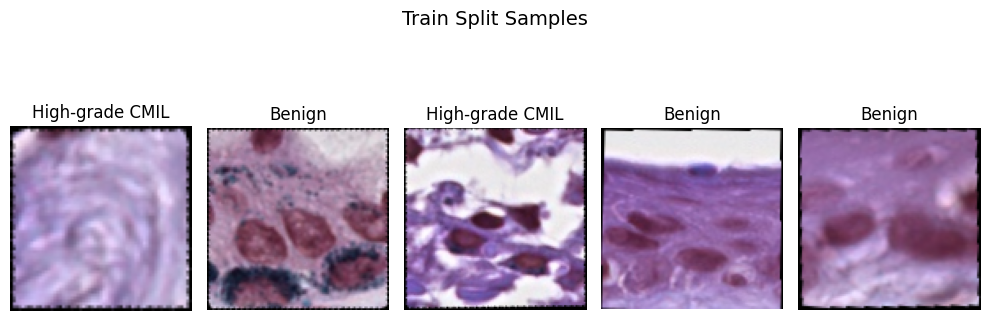


Train Set: Total Patches = 15659
  Benign (0):      8776
  High-grade (1):  6883

Validation Set: Total Patches = 5990
  Benign (0):      1979
  High-grade (1):  4011

Test Set: Total Patches = 7599
  Benign (0):      1567
  High-grade (1):  6032


In [15]:
def visualize_random_samples(meta_df, title="Samples", n_samples=5, max_candidates=20, n_threads=5):
    """
    Efficiently sample & plot `n_samples` images by:
      - Sampling up to `max_candidates` rows
      - Loading in parallel (ThreadPoolExecutor of size `n_threads`)
      - Skipping unreadable files
    """
    # 1) pick up to max_candidates random rows
    sample_paths = meta_df.sample(
        n=min(max_candidates, len(meta_df)),
        random_state=42
    ).path.tolist()

    # 2) helper to try to open one image
    def try_load(path):
        try:
            img = Image.open(path).convert('RGB')
            arr = np.array(img) / 255.0
            return path, arr
        except Exception:
            return None

    # 3) load in parallel, stop once we have n_samples
    loaded = []
    with ThreadPoolExecutor(max_workers=n_threads) as exe:
        futures = { exe.submit(try_load, p): p for p in sample_paths }
        for fut in as_completed(futures):
            res = fut.result()
            if res:
                loaded.append(res)
            if len(loaded) >= n_samples:
                break

    if not loaded:
        print("⚠️  Could not load any sample images.")
        return

    # 4) plot however many we got (up to n_samples)
    n = len(loaded)
    fig, axes = plt.subplots(figsize=(10, 4), ncols=n)
    fig.suptitle(title, fontsize=14)
    for ax, (path, arr) in zip(axes, loaded):
        ax.imshow(arr)
        cid = int(case_pat.search(os.path.basename(path)).group(1))
        cls = "Benign" if labels_map[cid] == 0 else "High-grade CMIL"
        ax.set_title(cls)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


# Usage – should now be under 15 seconds:
visualize_random_samples(train_meta, title="Train Split Samples")

# ─── Step 10: Fast class-distribution counts ──────────────────────────────────
def print_meta_stats(name, meta_df):
    # count using metadata case_number → labels_map
    lbls = [ labels_map[cid] for cid in meta_df.case_number if cid in labels_map ]
    cnt = Counter(lbls)
    total = len(lbls)
    print(f"\n{name} Set: Total Patches = {total}")
    print(f"  Benign (0):      {cnt.get(0,0)}")
    print(f"  High-grade (1):  {cnt.get(1,0)}")

print_meta_stats("Train",      train_meta)
print_meta_stats("Validation", val_meta)
print_meta_stats("Test",       test_meta)


**8) Model Definition and Training**

**Define Generalized Model Traininng Function**

In [16]:
# NEW TRAINING FUNCTION

# Helper: move tensors or lists of tensors to device
def move_batch_to_device(images, labels, device):
    if isinstance(images, (list, tuple)):
        images = torch.stack([img.to(device) for img in images])
    else:
        images = images.to(device)
    labels = labels.to(device)
    return images, labels

# Core training function
def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=3,
                scheduler=None, resume_from=None, device='cuda' if torch.cuda.is_available() else 'cpu'):

    train_losses = []
    val_losses = []
    val_accuracies = []

    model_dir = "/content/drive/MyDrive/STAT_390"
    os.makedirs(model_dir, exist_ok=True)

    model.to(device)
    best_acc = 0
    start_epoch = 0

    # Resume training if checkpoint exists
    if resume_from is not None and os.path.exists(resume_from):
        checkpoint = torch.load(resume_from, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        best_acc = checkpoint.get('val_accuracy', 0)
        print(f"🔁 Resumed from checkpoint at epoch {start_epoch} with accuracy {best_acc:.4f}")

    for e in range(start_epoch, epochs):
        model.train()
        running_loss = 0

        # Training phase
        train_bar = tqdm(train_loader, desc=f"Epoch {e+1}/{epochs}", leave=True)
        for images, labels, _ in train_bar:  # `_` = case_ids, ignored here
            images, labels = move_batch_to_device(images, labels, device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_bar.set_postfix(loss=running_loss / (train_bar.n + 1))

        epoch_train_loss = running_loss / len(train_loader)

        if scheduler:
            scheduler.step()

        # Validation phase
        model.eval()
        with torch.no_grad():
            validation_loss = 0
            correct = 0
            total = 0

            for images, labels, _ in val_loader:  # `_` = case_ids, ignored here
                images, labels = move_batch_to_device(images, labels, device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()

                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

            avg_val_loss = validation_loss / len(val_loader)
            val_accuracy = correct / total

        print(
            f"Epoch: {e+1}/{epochs}.. "
            f"Train Loss: {epoch_train_loss:.3f}.. "
            f"Val Loss: {avg_val_loss:.3f}.. "
            f"Val Accuracy: {val_accuracy:.3f}"
        )

        # Save checkpoint for every epoch
        torch.save({
            'epoch': e + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': epoch_train_loss,
            'val_loss': avg_val_loss,
            'val_accuracy': val_accuracy
        }, os.path.join(model_dir, f"model_epoch_{e+1}.pth"))

        # Save best model
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            torch.save(model.state_dict(), os.path.join(model_dir, "best_model.pth"))
            print(f"✅ New best model saved at epoch {e+1} with accuracy {val_accuracy:.4f}")

        train_losses.append(epoch_train_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

    # Plot training metrics
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss During Training')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy During Training')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

**Define Your Model and Train**

You need to specify 5 things (Do not specify anything else - they are already specified in the config)

1) Define your model object
```
model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT) # Use updated weights API
```
2) Unfreeze any layers that you want
```
for p in model.parameters(): p.requires_grad=False
```

3) Replace the classifier head if you want



```
in_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(in_ftrs, 2)
```



4) Define the optimizer and pass your trainable parameters

```
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = CONFIG["lr"])
```

5) Optional: Define your class weighting (for class imbalance) and update the criterion

```
from collections import Counter

def compute_class_weights(meta_df, labels_map):
    # Extract per‐patch labels
    lbls = [
        labels_map[int(cid)]
        for cid in meta_df.case_number
        if int(cid) in labels_map
    ]
    cnt = Counter(lbls)
    total = sum(cnt.values())
    # Inverse frequency: heavier weight for under-represented class
    w0 = total / cnt.get(0, 1)
    w1 = total / cnt.get(1, 1)
    return [w0, w1]

class_weights = compute_class_weights(train_meta, labels_map)

# Then your weighted‐loss setup becomes:
cw_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=cw_tensor)

```

If you are having trouble implementing this, plug-in these instructions and your model into ChatGPT.

In [17]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter

# Load pretrained CoaTNet and freeze all parameters
model = timm.create_model("coatnet_2_rw_224", pretrained=True, num_classes=2, drop_path_rate=0.3)
for p in model.parameters():
    p.requires_grad = False

# Override forward_features to exclude max pooling (if needed) and add adaptive pooling
class CustomCoaTNet(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base = base_model
        # Freeze original model parameters
        for p in self.base.parameters():
            p.requires_grad = False

        # Replace the classification head
        self.adaptive_pool = nn.AdaptiveAvgPool2d((6, 6))

        # Determine final feature map channel size
        self.feature_dim = self.base.num_features  # e.g., 1024 for coatnet_0

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(),
            nn.Linear(self.feature_dim * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2)
        )

    def forward(self, x):
        x = self.base.forward_features(x)  # extract features
        x = self.adaptive_pool(x)          # apply adaptive pooling
        return self.classifier(x)

# Wrap the model
model = CustomCoaTNet(model)

# Move model to device
device = CONFIG["device"]
model = model.to(device)

# 2) Optimizer over only trainable parameters
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=CONFIG["lr"]
)

# 3) Compute class weights for imbalance
def compute_class_weights(meta_df, labels_map):
    lbls = [labels_map[int(cid)] for cid in meta_df.case_number if int(cid) in labels_map]
    cnt = Counter(lbls)
    total = sum(cnt.values())
    return [total / cnt.get(0, 1), total / cnt.get(1, 1)]

class_weights = compute_class_weights(train_meta, labels_map)
cw_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=cw_tensor, label_smoothing=0.1)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/296M [00:00<?, ?B/s]

Epoch 1/15:   0%|          | 0/979 [00:00<?, ?it/s]

Epoch: 1/15.. Train Loss: 0.626.. Val Loss: 0.638.. Val Accuracy: 0.608
✅ New best model saved at epoch 1 with accuracy 0.6083


Epoch 2/15:   0%|          | 0/979 [00:00<?, ?it/s]

Epoch: 2/15.. Train Loss: 0.538.. Val Loss: 0.646.. Val Accuracy: 0.615
✅ New best model saved at epoch 2 with accuracy 0.6154


Epoch 3/15:   0%|          | 0/979 [00:00<?, ?it/s]

Epoch: 3/15.. Train Loss: 0.519.. Val Loss: 0.622.. Val Accuracy: 0.643
✅ New best model saved at epoch 3 with accuracy 0.6432


Epoch 4/15:   0%|          | 0/979 [00:00<?, ?it/s]

Epoch: 4/15.. Train Loss: 0.511.. Val Loss: 0.702.. Val Accuracy: 0.600


Epoch 5/15:   0%|          | 0/979 [00:00<?, ?it/s]

Epoch: 5/15.. Train Loss: 0.499.. Val Loss: 0.692.. Val Accuracy: 0.611


Epoch 6/15:   0%|          | 0/979 [00:00<?, ?it/s]

Epoch: 6/15.. Train Loss: 0.490.. Val Loss: 0.739.. Val Accuracy: 0.599


Epoch 7/15:   0%|          | 0/979 [00:00<?, ?it/s]

Epoch: 7/15.. Train Loss: 0.492.. Val Loss: 0.776.. Val Accuracy: 0.553


Epoch 8/15:   0%|          | 0/979 [00:00<?, ?it/s]

Epoch: 8/15.. Train Loss: 0.484.. Val Loss: 0.671.. Val Accuracy: 0.619


Epoch 9/15:   0%|          | 0/979 [00:00<?, ?it/s]

Epoch: 9/15.. Train Loss: 0.485.. Val Loss: 0.778.. Val Accuracy: 0.562


Epoch 10/15:   0%|          | 0/979 [00:00<?, ?it/s]

Epoch: 10/15.. Train Loss: 0.475.. Val Loss: 0.728.. Val Accuracy: 0.602


Epoch 11/15:   0%|          | 0/979 [00:00<?, ?it/s]

Epoch: 11/15.. Train Loss: 0.476.. Val Loss: 0.724.. Val Accuracy: 0.593


Epoch 12/15:   0%|          | 0/979 [00:00<?, ?it/s]

Epoch: 12/15.. Train Loss: 0.465.. Val Loss: 0.672.. Val Accuracy: 0.621


Epoch 13/15:   0%|          | 0/979 [00:00<?, ?it/s]

Epoch: 13/15.. Train Loss: 0.464.. Val Loss: 0.736.. Val Accuracy: 0.606


Epoch 14/15:   0%|          | 0/979 [00:00<?, ?it/s]

Epoch: 14/15.. Train Loss: 0.462.. Val Loss: 0.679.. Val Accuracy: 0.611


Epoch 15/15:   0%|          | 0/979 [00:00<?, ?it/s]

Epoch: 15/15.. Train Loss: 0.461.. Val Loss: 0.713.. Val Accuracy: 0.604


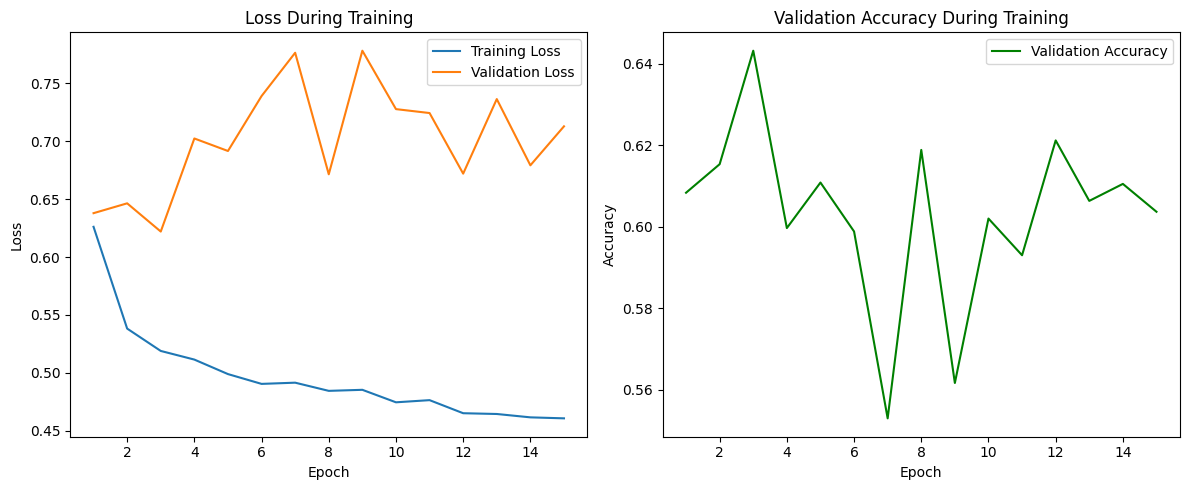

In [ ]:
# train model
trained_model = train_model(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=CONFIG['num_epochs'],
    scheduler=None,         # Optional: Replace with lr_scheduler if used
    resume_from=None,       # Optional: Replace with path to checkpoint if resuming
    device=CONFIG['device'] # Automatically uses 'cuda' or 'cpu'
)

**9. Model Evaluation**


=== Test Set Performance ===
Accuracy      : 0.6730
Precision     : 0.9022
Recall        : 0.6595
F1 Score      : 0.7620

Classification Report:
                 precision    recall  f1-score   support

         Benign       0.36      0.72      0.48      1567
High-grade CMIL       0.90      0.66      0.76      6032

       accuracy                           0.67      7599
      macro avg       0.63      0.69      0.62      7599
   weighted avg       0.79      0.67      0.70      7599



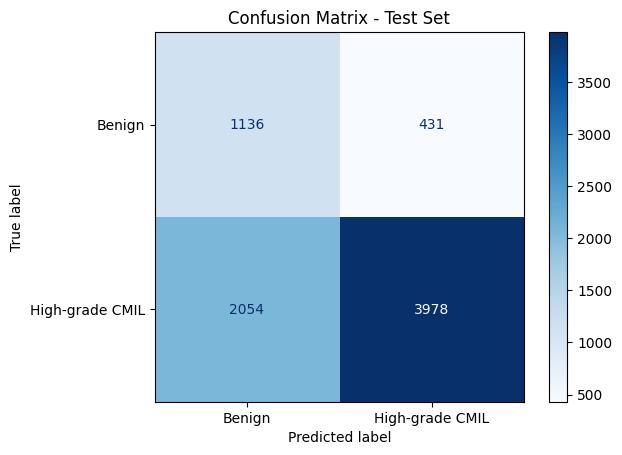

In [ ]:
def evaluate_model_on_test(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels, _ in test_loader:  # `_` = case IDs (optional)
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # === Compute Metrics ===
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print("\n=== Test Set Performance ===")
    print(f"Accuracy      : {acc:.4f}")
    print(f"Precision     : {prec:.4f}")
    print(f"Recall        : {rec:.4f}")
    print(f"F1 Score      : {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Benign", "High-grade CMIL"]))

    # === Plot Confusion Matrix ===
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "High-grade CMIL"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix - Test Set")
    plt.show()

# === Run Evaluation ===
evaluate_model_on_test(trained_model, test_loader, CONFIG['device'])


**10. Patch Level to Case Level Prediction**

In [ ]:
def evaluate_model_case_level_svc(model, df_train, df_test, train_loader, test_loader, k=25, tune_svc = False, return_pred = False):

    # === Collect model predictions for train and test datasets ===

    model.eval()
    all_probs_tr, all_probs_tst = [], []
    with torch.no_grad():
        for images, labels, _ in train_loader:
            images= (images.to(device))
            outputs = model(images)
            probs   = softmax(outputs, dim=1)
            all_probs_tr.extend(probs.cpu().numpy())

        for images, labels, _ in test_loader:
            images = (images.to(device))
            outputs = model(images)
            probs   = softmax(outputs, dim=1)
            all_probs_tst.extend(probs.cpu().numpy())
    train_prob = [arr[0] for arr in all_probs_tr]
    test_prob = [arr[0] for arr in all_probs_tst]
    print(len(test_prob))

    # === Produce top k predicted probability dataframe for train data ===
    if df_train['stain'].nunique() > 1:
        all_top_k = []
        for stain in df_train['stain'].unique():
            df_train_rs = df_train.reset_index(drop=True)
            stain_df = df_train_rs[df_train_rs['stain']==stain]
            stain_prob = [train_prob[x] for x in stain_df.index]
            stain_top_k_prob = pd.DataFrame({'case_number': stain_df.case_number.values, 'prob': stain_prob}).groupby('case_number', group_keys=False)[['case_number','prob']].apply(lambda x: x.nlargest(25, columns='prob')).reset_index(drop=True)
            stain_top_k_prob['rank'] = top_k_prob.groupby('case_number').cumcount()
            stain_top_k_prob = top_k_prob.pivot(index='case_number', columns='rank', values='prob').dropna()
            stain_top_k_prob.columns = [f'{stain}_prob_{col}' for col in stain_top_k_prob.columns]
            all_top_k.append(stain_top_k_prob)
        top_k_prob = pd.concat(all_top_k, axis=1).dropna(axis=0)
        case_label = df_train[df_train.case_number.isin(top_k_prob.index)].groupby('case_number')['label'].mean()
    else:
        df_train['label'] = df_train['case_number'].map(labels_map)
        top_k_prob = pd.DataFrame({'case_number': df_train.case_number.values, 'prob': train_prob}).groupby('case_number', group_keys=False)[['case_number','prob']].apply(lambda x: x.nlargest(k, columns='prob')).reset_index(drop=True)
        top_k_prob['rank'] = top_k_prob.groupby('case_number').cumcount()
        top_k_prob = top_k_prob.pivot(index='case_number', columns='rank', values='prob').dropna()
        case_label = df_train[df_train.case_number.isin(top_k_prob.index)].groupby('case_number')['label'].mean()

    # === Make and fit SVC to train predicted probabilities ===
    if tune_svc:
        pipeline = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
        param_grid = [
            {'svc__kernel': ['linear'], 'svc__C': [0.01, 0.1, 1, 10, 100]},
            {'svc__kernel': ['rbf'], 'svc__C': [0.1, 1, 10], 'svc__gamma': ['scale', 0.01, 0.001, 0.0001]}
        ]
        svc = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy')
        svc.fit(top_k_prob, case_label)
        print('Selected parameters: ' + str(svc.best_params_))
    else:
        svc = make_pipeline(StandardScaler(), LinearSVC())
        svc.fit(top_k_prob, case_label)

    # === Produce top k predicted probability dataframe for test data ===
    df_test = df_test.dropna()
    if df_train['stain'].nunique() > 1:
        all_top_k = []
        for stain in df_train['stain'].unique():
            df_test_rs = df_test.reset_index(drop=True)
            stain_df = df_test_rs[df_test_rs['stain']==stain]
            stain_prob = [test_prob[x] for x in stain_df.index]
            stain_top_k_prob_tst = pd.DataFrame({'case_number': stain_df.case_number.values, 'prob': stain_prob}).groupby('case_number', group_keys=False)[['case_number','prob']].apply(lambda x: x.nlargest(25, columns='prob')).reset_index(drop=True)
            stain_top_k_prob_tst['rank'] = stain_top_k_prob_tst.groupby('case_number').cumcount()
            stain_top_k_prob_tst = stain_top_k_prob_tst.pivot(index='case_number', columns='rank', values='prob').dropna()
            stain_top_k_prob_tst.columns = [f'{stain}_prob_{col}' for col in top_k_prob_tst.columns]
            all_top_k.append(stain_top_k_prob_tst)
        top_k_prob_tst = pd.concat(all_top_k, axis=1).dropna(axis=0)
        case_label_tst = df_test[df_test.case_number.isin(top_k_prob_tst.index)].groupby('case_number')['label'].mean()
    else:
        df_test['label'] = df_test['case_number'].map(labels_map)
        top_k_prob_tst = pd.DataFrame({'case_number': df_test.case_number.values, 'prob': test_prob}).groupby('case_number', group_keys=False)[['case_number','prob']].apply(lambda x: x.nlargest(k, columns='prob')).reset_index(drop=True)
        top_k_prob_tst['rank'] = top_k_prob_tst.groupby('case_number').cumcount()
        top_k_prob_tst = top_k_prob_tst.pivot(index='case_number', columns='rank', values='prob').dropna()
        case_label_tst = df_test[df_test.case_number.isin(top_k_prob_tst.index)].groupby('case_number')['label'].mean()

    # === Calculate and print train metrics ===
    train_pred = svc.predict(top_k_prob)
    train_acc = accuracy_score(case_label, train_pred)
    train_rec = recall_score(case_label, train_pred)
    train_pre = precision_score(case_label, train_pred, zero_division=0)
    train_f1 = f1_score(case_label, train_pred, zero_division=0)
    print("\n=== Train Set Performance ===")
    print('Train Accuracy: ' + str(train_acc))
    print('Train Precision ' + str(train_pre))
    print('Train Recall: ' + str(train_rec))
    print('Train F1 Score: ' + str(train_f1))

    # === Calculate and print test metrics ===
    test_pred = svc.predict(top_k_prob_tst)
    test_acc = accuracy_score(case_label_tst, test_pred)
    test_rec = recall_score(case_label_tst, test_pred)
    test_pre = precision_score(case_label_tst, test_pred, zero_division=0)
    test_f1 = f1_score(case_label_tst, test_pred, zero_division=0)
    print("\n=== Test Set Performance ===")
    print('Test Accuracy: ' + str(test_acc))
    print('Test Precision ' + str(test_pre))
    print('Test Recall: ' + str(test_rec))
    print('Test F1 Score: ' + str(test_f1))
    print("\nClassification Report:")
    print(classification_report(case_label_tst, test_pred, target_names=["Benign", "High-grade CMIL"]))

    # === Produce and plot confusion matrix for test data ===
    cm = confusion_matrix(case_label_tst, test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.xticks(ticks=[0,1], labels=['Benign', 'High-grade CMIL'])
    plt.yticks(ticks=[0,1], labels=['Benign', 'High-grade CMIL'])
    plt.xlabel('Predicted Case Grade')
    plt.ylabel('Actual Case Grade')
    plt.title("Confusion Matrix - Test Set Case Level")
    plt.show()

    if return_pred:
        return svc.predict(top_k_prob_tst)
    else:
        return None

In [ ]:
# === Run Case-Level Model Evaluation ===
evaluate_model_case_level_svc(model, train_meta, test_meta, train_loader, test_loader, 25, tune_svc=True)

In [ ]:
from google.colab import runtime
runtime.unassign()

**End of script – see below for other examples of correct model setups**

trained_model = train_model(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=CONFIG['num_epochs'],
    scheduler=None,
    resume_from=None,
    device=CONFIG['device']
)